In [1]:
import os
from glob import glob
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import linear_model
from sklearn.metrics import RocCurveDisplay, auc, mean_squared_error, roc_curve
from sklearn.model_selection import RandomizedSearchCV
from sklearn.utils.fixes import loguniform
from scipy.interpolate import interp1d

from label_flip_revised.utils import create_dir

In [2]:
PATH_ROOT = Path(os.getcwd()).absolute().parent
print(PATH_ROOT)

/home/lukec/workspace/diva_01


In [3]:
path_output = os.path.join(PATH_ROOT, 'results_plot')
print(path_output)
create_dir(path_output)

/home/lukec/workspace/diva_01/results_plot


In [4]:
NAMES = {
    'falfa_nn': 'FALFA',
    'alfa_svm': 'ALFA',
    'poison_svm': 'PoisSVM',
}
COLORS_1 = {
    'Hard': '#9c27b0',
    'Normal': '#1976d2',
    'Easy': '#f57f17',
}
COLORS_2 = {
    'falfa_nn': '#d32f2f',
    'alfa_svm': '#1976d2',
    'poison_svm': '#388e3c',
}
DIF_LEVELS = ['Hard', 'Normal', 'Easy']

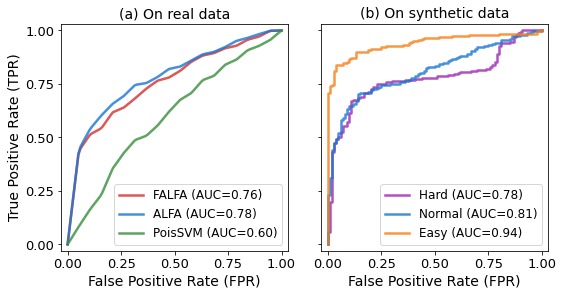

In [5]:
FONTSIZE = 13
FIGSIZE = (8, 4)
TITLES = [
    '(a) On real data',
    '(b) On synthetic data',
]
LINE_WIDTH = 2.5

plt.rcParams["font.size"] = FONTSIZE
fig, axes = plt.subplots(1, 2, sharex=True, sharey=True, figsize=FIGSIZE)

for att in ['falfa_nn', 'alfa_svm', 'poison_svm']:
    df_ = pd.read_csv(os.path.join(path_output, f'real_roc_mean_{att}.csv'))
    fpr_ = df_['fpr'].to_numpy()
    tpr_ = df_['tpr'].to_numpy()
    roc_auc_ = auc(fpr_, tpr_)

    func = interp1d(fpr_, tpr_, kind='slinear')
    fpr_smooth = np.linspace(0, 1, 100, endpoint=True)
    tpr_smooth = func(fpr_smooth)
    roc_display = RocCurveDisplay(fpr=fpr_smooth, tpr=tpr_smooth, roc_auc=roc_auc_).plot(
        ax=axes[0], name=NAMES[att], c=COLORS_2[att], alpha=0.8, linewidth=LINE_WIDTH)

for dif in DIF_LEVELS:
    df_ = pd.read_csv(os.path.join(path_output, f'synth_roc_{dif}.csv'))
    fpr_ = df_['fpr'].to_numpy()
    tpr_ = df_['tpr'].to_numpy()
    roc_auc_ = auc(fpr_, tpr_)
    roc_display = RocCurveDisplay(fpr=fpr_, tpr=tpr_, roc_auc=roc_auc_).plot(
        ax=axes[1], name=dif, c=COLORS_1[dif], alpha=0.8, linewidth=LINE_WIDTH)

label_dict = {}
for i in range(2):
    ax = axes[i]
    ax.set_aspect('equal')
    ax.set_ylabel('')
    ax.set_xlabel('False Positive Rate (FPR)', fontsize=FONTSIZE+1)
    ax.set(xlim=[-0.03, 1.03], ylim=[-0.03, 1.03])
    ax.set_xticks(np.linspace(0, 1, num=5), fontsize=FONTSIZE-1)
    ax.set_yticks(np.linspace(0, 1, num=5), fontsize=FONTSIZE-1)
    ax.set_title(TITLES[i], fontsize=FONTSIZE+1)

    lines, labels = ax.get_legend_handles_labels()
    labels = [s.split()[0] + ' ' + ''.join(s.split()[1:]) for s in labels]
    ax.legend(lines, labels, fontsize=FONTSIZE-1, loc='lower right')

axes[0].set_ylabel('True Positive Rate (TPR)', fontsize=FONTSIZE+1)

plt.tight_layout(pad=0.8)
plt.savefig(os.path.join(path_output, 'roc.pdf'), dpi=300)